# Sub-graphs

## Review

In the past 3 modules, we've built an understanding of LangGraph fundementals, agent fundementals, state, memory, and human-in-the-loop!

## Context

Now, let's bring them togther in a practical example that does two things:

* Leverages a wide set of LangGraph capabilities
* Is generally interesting and fun

With fall around the corner, [Fantasy Football](https://fantasy.nfl.com/) becomes a popular online game where participants act as managers of virtual professional football teams. The goal is to assemble a team of real-life NFL players and score points based on their statistical performance in actual games. We have a small league in our office, and I wanted to create an agent that can:

* Ingest a few different sources of information (e.g., on an ongoing basis)
* Analyze it to produce `takes` related to these information sources (e.g., players, team, games, or match-ups in our league )
* Write the `takes` to a public Slack in our office as a source of humor and engagement 

While it's a fun and kind of silly use-case, it actually ties together a number of interesting / advanced LangGraph features. It also relates to a broader set of themes that we've seen in building agent systems:

1) `Insight Generation` -- While there is high interest in RAG question-answering systems, [there is growing interest in systems that use RAG as a step in the generation of higher-level insights, such as reports or summaries](https://jxnl.co/writing/2024/06/05/predictions-for-the-future-of-rag/). 

2) `Automating multi-step research workflows` -- There are some interesting examples of AI-mediated workflows that replace general knowlege work. For example, [deal flow automation for VCs](https://x.com/MaxBrodeurUrbas/status/1806380947606253960) that analyzes pitch decks. Systems that can ingest arbitrary information sources and produce distilled information artifacts are interesting in this vein. 

3) `Multi-perspective AI assistants` -- A generally powerful approach, as seen in papers like [STORM](https://github.com/langchain-ai/langgraph/blob/main/examples/storm/storm.ipynb), is to create AI assistants that take on various roles and have them simultanously research a topic. 

With these points in mind, we'll lay out our agent as shown here and we'll walk through the creation of each component in the following sessions! 

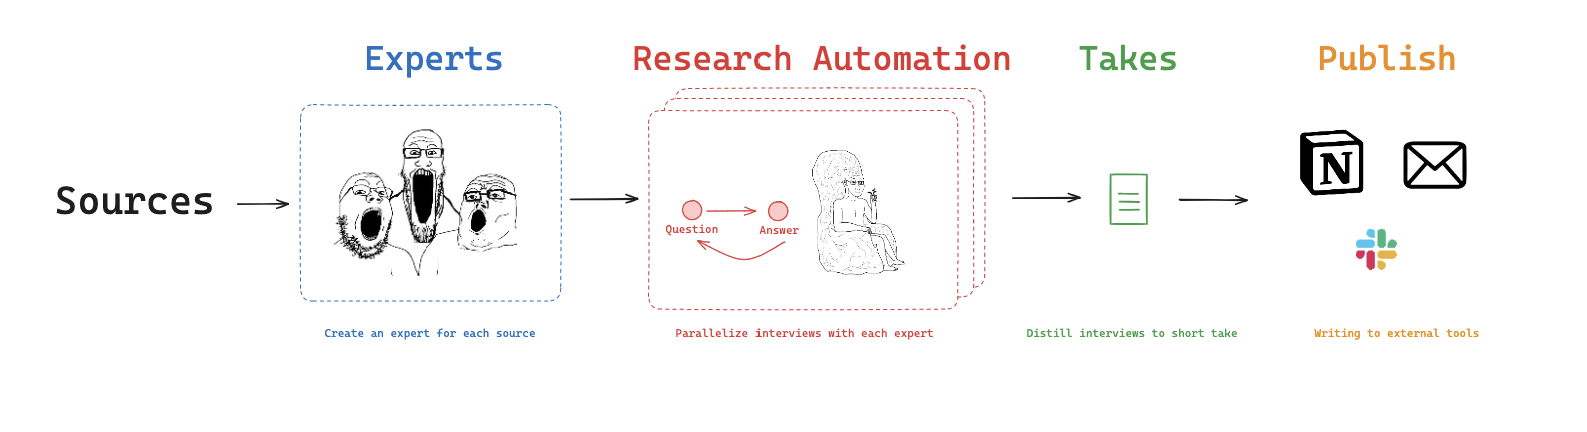

## Goals
 
First, we'll lay out the basics of our `take-bot` agent, creating a set of experts and the ability to conduct interviews with them.
  
We'll introduce the idea of [sub-graphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/) to perform these interviews.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai praw

## Gather expert sources

First, let's gather sources that we want our experts to use. 

Of course, this is very flexible! You can use whatever sources you want.

I'll use [the Reddit Fantasy Football sub](https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/), which tends to have interesting insights.
 
We'll use PRAW, the [Python Reddit API Wrapper](https://praw.readthedocs.io/en/stable/).

To use it, log into Reddit and go here to [create an app](https://www.reddit.com/prefs/apps).  

Once you create an app, you'll see `REDDIT_CLIENT_ID` below your name and `REDDIT_CLIENT_SECRET` in the app window. 
 
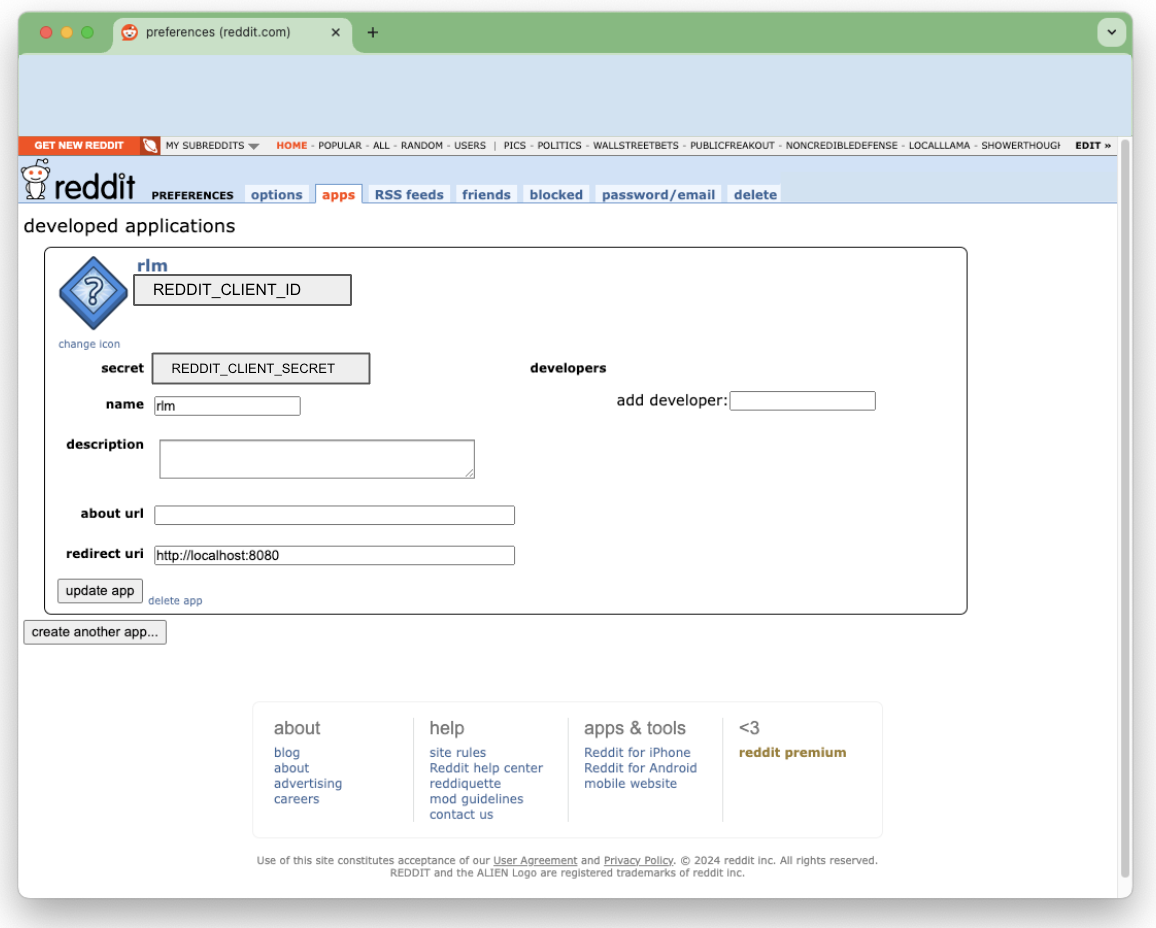

The central point is that you'll turn information from reddit posts into a document `reddit_expert_context` for your expert to use.

In [160]:
import os
import praw

# Reddit creds
reddit_client_id = os.getenv('REDDIT_CLIENT_ID')
reddit_client_secret = os.getenv('REDDIT_CLIENT_SECRET')

# Initialize the Reddit instance
reddit = praw.Reddit(client_id=reddit_client_id,
                     client_secret=reddit_client_secret,
                     user_agent='Fantasy Football Loader')

You can customize this in any way!

We'll simply pull from this sub ~ daily for our `takes-bot`.

In [167]:
def get_recent_reddit_posts(subreddit_name,
                            filter_to_use,
                            number_of_posts,
                            number_of_comments,
                           ):

    ''' Get comments from top posts in a particular subreddit '''

    # Access the subreddit
    subreddit = reddit.subreddit(subreddit_name)
    
    # Get top posts based on the specified filter
    top_posts = subreddit.top(time_filter=filter_to_use, limit=number_of_posts)
    
    # Initialize an empty string to store the output
    reddit_expert_context = ""
    
    # Process each post
    for post in top_posts:
        reddit_expert_context += f"Title: {post.title}\n"
        reddit_expert_context += f"URL: {post.url}\n"
        reddit_expert_context += f"Score: {post.score}\n"
        
        post.comments.replace_more(limit=0)  # Flatten the comment tree
        
        # Get the specified number of top comments
        for i, comment in enumerate(post.comments[:number_of_comments]):
            reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
            reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

# Replace with the subreddit you're interested in
subreddit_name = 'fantasyfootball'

# Get top comments from past <day, month, etc>
filter_to_use = 'day'

# Number of posts to gather
number_of_posts = 5

# Number of top comments to gather per post
number_of_comments = 10

reddit_recent_posts = get_recent_reddit_posts(subreddit_name,
                                              filter_to_use,
                                              number_of_posts,
                                              number_of_comments)

In [165]:
reddit_recent_posts[0:200]

'Title: Lions RB Jahmyr Gibbs, who has been dealing with a leg injury, is out on the field running routes and catching passes from Jared Goff \nURL: https://x.com/bridgetcondon_/status/18273498958432873'

We can alo gather information for specific posts of interest!

For example, here there are some useful deep dives on Fantasy Draft strategy that we want more information from.

In [171]:
def get_reddit_post(url,
                   number_of_comments):
    
    ''' Get reddit post comments '''

    # Fetch the submission
    post = reddit.submission(url=url)
    
    # Load the comments
    post.comments.replace_more(limit=None) # Flatten the comment tree
    comments = post.comments.list()

    # Initialize an empty string to store the output
    reddit_expert_context = ""
    reddit_expert_context += f"Title: {post.title}\n"
    reddit_expert_context += f"URL: {post.url}   \n"
    reddit_expert_context += f"Post: {post.selftext}\n"

    # Get the specified number of top comments
    for i, comment in enumerate(post.comments[:number_of_comments]):
        reddit_expert_context += f"Top Comment {i+1}: {comment.body}\n"
        reddit_expert_context += f"Comment Score: {comment.score}\n\n"
        reddit_expert_context += "="*50 + "\n\n"

    return reddit_expert_context

url = "https://www.reddit.com/r/fantasyfootball/comments/1ewk6kr/theres_only_one_draft_strategy_that_ill_ever/"
number_of_comments = 20
reddit_draft_strategy_context = get_reddit_post(url,number_of_comments)

url = "https://www.reddit.com/r/fantasyfootball/comments/1espdv7/who_is_one_guy_you_arent_leaving_the_draft/"
number_of_comments = 20
reddit_top_player_context = get_reddit_post(url,number_of_comments)

## Create experts

The expert will use this LLM to answer questions.

In [176]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0) 

Define the schema for each expert.

In [177]:
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

class Expert(BaseModel):
    name: str = Field(
        description="Name of the expert.", pattern=r"^[a-zA-Z0-9_-]{1,64}$"
    )
    role: str = Field(
        description="Role of the expert.",
    )
    context: SystemMessage = Field(
        description="Instructions used by the expert.",
    )

    def answer(self, dicussion: List) -> AIMessage:
        return llm.invoke([self.context]+dicussion)

Define the schema the `takes` that we'll publish to Slack.

In [211]:
class Take(BaseModel):
    title: str = Field(
        description="Punchy summary title for the take or perspective",
    )
    take: str = Field(
        description="Fun, punchy observation from the discussion between expert and interviewer.",
    )

class Takes(BaseModel):
    takes: List[Take] = Field(
        description="A list of takes, each containing a title and a take observation."
    )

Overall graph state.

In [181]:
import operator

class OverallState(InterviewOutputState):
    topic: str
    experts: List[Expert]
    takes: Annotated[List[Take], operator.add]

Now, generate our experts.

In [182]:
from langchain_core.runnables import chain as as_runnable

@as_runnable
def generate_experts(state: OverallState):
    """ Generate our experts """
    
    preamble = "You are an expert in in Fantasy Football. You are being interviewed by an analyst. Don't make up your own answers."
    
    draft_strategy_expert = Expert(
        name="Moe",
        role="Fantasy Draft Strategy Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {reddit_draft_strategy_context}"),
    )
    
    top_player_expert = Expert(
        name="Jimbo",
        role="Top Players To Draft Expert",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {reddit_top_player_context}"),
    )

    recent_events_expert = Expert(
        name="Barney",
        role="Following recent news",
        context=SystemMessage(content=f"{preamble} Use only this information to answer questions from the analyst: {reddit_recent_posts}"),
    )

    return {"experts": [draft_strategy_expert, top_player_expert, recent_events_expert]}

In [183]:
# Test this! 
topic = "A strategy for top players to draft in Fantasy Football."
experts = generate_experts.invoke({"topic":topic})

In [137]:
# Let's ask either of our experts a question
result = experts['experts'][1].answer([HumanMessage(content="Tell me an under-rated running back to draft", name='Interviewer')])
result

AIMessage(content="One under-rated running back to consider drafting is Kenneth Walker. His ADP is lower than several other running backs who have more question marks surrounding them. Walker has an established role with the Seahawks, and the new coach/OC love him. The Seahawks are expected to increase their pace of play, which should provide more opportunities for Walker. Additionally, the running backs being drafted ahead of him, such as Rachaad White, Joe Mixon, and Alvin Kamara, have their own inefficiencies and risks. Walker's situation and potential make him a valuable pick, especially considering his current ADP.", response_metadata={'token_usage': {'completion_tokens': 120, 'prompt_tokens': 36435, 'total_tokens': 36555}, 'model_name': 'gpt-4o-2024-05-13', 'system_fingerprint': 'fp_df84d6bd70', 'finish_reason': 'stop', 'logprobs': None}, id='run-cb8955d5-a779-4f79-a828-f351f34a08d0-0', usage_metadata={'input_tokens': 36435, 'output_tokens': 120, 'total_tokens': 36555})

## Create interview sub-graph

We've created experts based upon our information sources.

We can ask them questions. 

And we've defined an overall graph state. 

Now, let's start to bring in the idea of a `sub-graph`.

The main benefit is: a `sub-graph` can have its own state, which we may refer to as an `inner state` vs the `outer state` (`OverallState`).

In particular, it will contain a few keys that we don't need in the `outer state`, the `messages`.

Let's use what we learned about multiple schema! The output of the interview will only be our list of takes.

In [184]:
from langgraph.graph import MessagesState

# Specify the maximum number of answers we want each expert to give
max_num_turns = 2

# Define our state 
class InterviewState(MessagesState):
    topic: str
    expert: Expert
    
class InterviewOutputState(TypedDict):
     takes: List[Take]

Now, we'll simulate an interview between each expert and an interviewer.
  
We'll have an LLM role-play as an interviewer.

In [185]:
@as_runnable
def generate_question(state: InterviewState):
    """ Node to generate a question """

    instructions = SystemMessage(content=f"""
    
    You are an analyst named Lance tasked with interviewing an expert to learn about a specific topic. 
    
    Here is the topic: {state["topic"]}
    
    Focus on insights that avoid generalities and include specific examples from the expert.
    
    Begin by introducing yourself, and then ask your starting question.
    
    Continue to ask questions to drill down and refine your understanding of the topic.
    
    As the interview proceeds, consider if you question has been answered. 
    
    If it has been answered, then complete the interview with: "Thank you so much for your help!"
    
    Remember to stay in character throughout your responses.""")
    
    # Generate question 
    result = llm.invoke([instructions]+state["messages"])   
    
    # Write to state
    return {"messages": [HumanMessage(content=result.content, name='Interviewer')]}

Now, use an expert to answer question.

In [197]:
@as_runnable
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    messages = state["messages"]
    expert = state["expert"]
   
    # Answer question
    answer = expert.answer(messages)
    
    # Use the generate name "expert" to count expert responses
    answer.name = 'expert'
    
    # Write to state
    return {"messages": [answer]}

Use `structured output` to generate takes.

In [201]:
@as_runnable
def generate_takes(state: InterviewState):
    """ Node to answer a question """

    # Get discussion
    messages = state["messages"]

    # Instructions
    instructions = SystemMessage(content=f"""
    
    Distill the conversation between the analyst and expert into a set of fun and informative takes. 
    
    Each take should have a punchy subject line. 
    
    Each take should be specific and provide examples to back-up the statement.
    
    Aim for 5 - 10 different takes per interview that 1) cover the most interesting points raised and 2) avoid repetition.""")

    # Enforce structured output
    structured_llm = llm.with_structured_output(Takes)
    
    # Generate takes
    takes = structured_llm.invoke([instructions]+messages)
        
    # Write to state
    return {"takes": takes}

Now we add logic to determine when to finish the interview.

We finish if `>= max_num_turns` expert answers or if the interviewer says they are satisfied. 

For the latter, we instructed the interviewer to say `"Thank you so much for your help!"` when they are done.

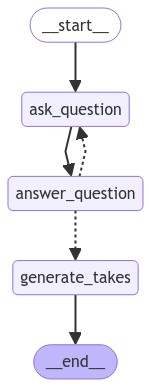

In [202]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START
from langgraph.checkpoint.memory import MemorySaver

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return "generate_takes"

    # This router is run after each question - answer pair 
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return "generate_takes"
    return "ask_question"

# Add nodes and edges 
interview_builder = StateGraph(input=InterviewState, output=InterviewOutputState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("generate_takes", generate_takes)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','generate_takes'])
interview_builder.add_edge("generate_takes", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory)

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

Now, let's simulate an interview with one expert!

In [203]:
for e in experts['experts']:
    print(e.name, e.role)

Moe Fantasy Draft Strategy Expert
Jimbo Top Players To Draft Expert
Barney Following recent news


In [204]:
# Let's pick Jimbo, the expert in top players to draft
thread = {"configurable": {"thread_id": "11"}}
result = interview_graph.invoke({"topic":topic, 
                                 "expert":experts['experts'][1]}, thread)

The output state only contains the `takes`.

We can look at the trace:

https://smith.langchain.com/public/03270a74-26ea-4ec2-a50d-fd06d6249e84/r

Token usage is pretty low for a 2-turn conversation. 

This can be tuned very easily! Simply 1) increace the number of turns to go deeper on a subject ot 2) pull more posts / comments into context.

In [208]:
from IPython.display import Markdown, display
for take in result['takes'].takes:
    display(Markdown(f"### {take.title}\n{take.take}\n{take.url}\n"))

### Value Hunters: The Secret Sauce of Top Fantasy Players
Top Fantasy Football players excel at identifying value and avoiding overpaying for players. They understand player ADPs and can spot when a player like Malik Nabers is undervalued or when someone like Chris Olave is overvalued due to limited role and poor QB play.
Interviewer and Expert Discussion


### Flexibility Wins Drafts: Adapting on the Fly
Top players are flexible and adaptable during drafts. For example, if a run on wide receivers leaves slim pickings, they might pivot to a high-upside running back like Kenneth Walker, who has an established role and is favored by his new coach/OC.
Interviewer and Expert Discussion


### Late-Round Gems: The Key to a Strong Roster
Top players often find value in later rounds by targeting players like Jake Ferguson, who has a clear path to being a significant target in the Cowboys' offense. This strategy helps them build a more balanced and stronger team.
Interviewer and Expert Discussion


### Avoiding the Trap: Recognizing Overvalued Players
Top players avoid overvalued players like Chris Olave, who, despite his talent, is seen as overvalued due to his limited role and poor QB play. This helps them avoid wasting valuable draft picks on players who may not deliver.
Interviewer and Expert Discussion


### High-Upside Targets: Betting on Potential
Top players target high-upside players like Malik Nabers, who is seen as a high upside flex and has been dominating training camp. They recognize the potential for him to shatter expectations and provide significant value.
Interviewer and Expert Discussion


### The Art of the Pivot: Changing Strategies Mid-Draft
Top players can pivot their strategy mid-draft based on how the draft is unfolding. For example, if their plan to draft a tight end early falls through, they might wait and target a later-round value like Jake Ferguson instead.
Interviewer and Expert Discussion


## Overall graph

Great! So we can generate takes from the interview.

Now, let's embed this interview within our overall graph. 

Note that when we run:
```
overall_builder.add_node("conduct_interview", interview_builder.compile())
```

This will compile the interview sub-graph with its own `InterviewState` as part of the overall graph!

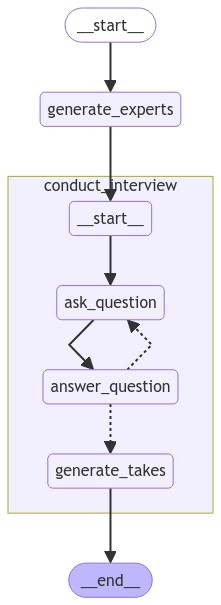

In [206]:
# Add nodes and edges 
overall_builder = StateGraph(OverallState)

# Add nodes and edges 
overall_builder.add_node("generate_experts", generate_experts)
overall_builder.add_node("conduct_interview", interview_builder.compile())

overall_builder.add_edge(START, "generate_experts")
overall_builder.add_edge("generate_experts", "conduct_interview")
overall_builder.add_edge("conduct_interview", END)
graph = overall_builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

Now, we can generate our experts and kick off a conversation to generate takes.

How can we parallelize these conversations to speed up our overall agent?